# Intro
https://link.springer.com/chapter/10.1007/978-981-13-8798-2_12

The dataset referenced in this paper contains 520 observations and 17 attributes that are collected
using direct questionnaires and diagnosis results from the patients in the Sylhet Diabetes Hospital
in Sylhet, Bangladesh. There are 2 demographic features, Age & Gender; the other 15 attributes
are binary features that indicate whether the patient experienced a symptom

By the due date of milestone report on 10/23, we should be able to reproduce the results from the first
paper. For the milestone report, we will each tackle an algorithm and attempt to reproduce the results
from (Islam et al. 2020). With the exception of Decision Tree/Random Forest, this corresponds with
the material taught on the syllabus.

## Explore

In [ ]:
# %pip install --user pandas_profiling

In [7]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

###sklearn
from sklearn import (
    ensemble,
    feature_selection,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    tree,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.tree import export_graphviz

from pandas_profiling import ProfileReport


sns.set(rc={"axes.facecolor": "white", "figure.facecolor": "white"})

In [17]:
sylhet_raw = pd.read_csv("../data/pima-diabetes.csv")
sylhet_copy = sylhet_raw.copy(deep=True)

In [18]:
sylhet_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [19]:
profile = ProfileReport(sylhet_copy)

In [20]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# profile

In [22]:
col_names = [x.lower().replace(" ", "_") for x in sylhet_copy.columns]

print(col_names)

sylhet_copy.set_axis(col_names, axis=1, inplace=True)

# print(sylhet_copy.columns)

['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi', 'diabetespedigreefunction', 'age', 'outcome']


In [23]:
sylhet_copy.head(5)

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [24]:
sylhet_copy["outcome"].unique()

array([1, 0])

In [25]:
y = sylhet_copy["outcome"].to_numpy()

In [26]:
sylhet_copy = sylhet_copy.loc[:, :"age"]

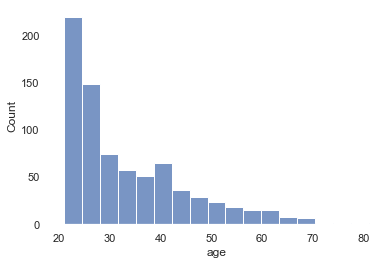

In [27]:
sns.histplot(sylhet_copy, x="age").figure.savefig("age_distribution_histogram.png")

In [28]:
age_binned = pd.qcut(sylhet_copy["age"], q=6)

In [29]:
age_binned.value_counts(sort=False, ascending=True)

(20.999, 22.0]    135
(22.0, 25.0]      132
(25.0, 29.0]      129
(29.0, 36.0]      118
(36.0, 45.0]      136
(45.0, 81.0]      118
Name: age, dtype: int64

In [30]:
sylhet_copy["age"] = age_binned

In [32]:
sylhet_copy.columns

Index(['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin',
       'bmi', 'diabetespedigreefunction', 'age'],
      dtype='object')

In [ ]:
# column_trans = ColumnTransformer(
#     [('age_bins', KBinsDiscretizer(n_bins=6, encode='onehot-dense', strategy='quantile'),['age']),
#       ('one_hot', OneHotEncoder(), list(sylhet_copy.columns[1:-1].values))
#     ],remainder='passthrough'
# )

In [33]:
column_trans = ColumnTransformer(
    [("one_hot", OneHotEncoder(drop="if_binary"), ['age']),
    ('minmax', MinMaxScaler(),['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin',
       'bmi', 'diabetespedigreefunction'])],
    remainder="passthrough",
)

In [34]:
column_trans.fit(sylhet_copy)

ColumnTransformer(remainder='passthrough',
                  transformers=[('one_hot', OneHotEncoder(drop='if_binary'),
                                 ['age']),
                                ('minmax', MinMaxScaler(),
                                 ['pregnancies', 'glucose', 'bloodpressure',
                                  'skinthickness', 'insulin', 'bmi',
                                  'diabetespedigreefunction'])])

In [35]:
column_trans.get_feature_names_out()

array(['one_hot__age_(20.999, 22.0]', 'one_hot__age_(22.0, 25.0]',
       'one_hot__age_(25.0, 29.0]', 'one_hot__age_(29.0, 36.0]',
       'one_hot__age_(36.0, 45.0]', 'one_hot__age_(45.0, 81.0]',
       'minmax__pregnancies', 'minmax__glucose', 'minmax__bloodpressure',
       'minmax__skinthickness', 'minmax__insulin', 'minmax__bmi',
       'minmax__diabetespedigreefunction'], dtype=object)

In [36]:
X = column_trans.transform(sylhet_copy)

In [37]:
X.shape

(768, 13)

In [38]:
MLA = [
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    linear_model.LogisticRegression(),
    tree.DecisionTreeClassifier(min_samples_split=10, min_samples_leaf=10, max_depth=4),
    ensemble.RandomForestClassifier(
        max_depth=4, min_samples_split=10, min_samples_leaf=10
    ),
]

In [39]:
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(
    X, y, random_state=42, train_size=0.8, test_size=0.2
)

In [40]:
print(train1_x.shape, train1_y.shape)
print(test1_x.shape, test1_y.shape)

(614, 13) (614,)
(154, 13) (154,)


In [41]:
np.unique(test1_y, return_counts=True)

(array([0, 1]), array([99, 55]))

In [42]:
score_cols = [
    "Model Name",
    "Precision",
    "Recall",
    "F1",
    "Train Accuracy",
    "Test Accuracy",
]
model_compare = pd.DataFrame(columns=score_cols)

In [45]:
results_conf = pd.DataFrame(
    columns=[
        "true_negative",
        "false_positive",
        "false_negative",
        "true_positive",
        "model",
    ]
)
results = pd.DataFrame(
    index=["negative", "positive", "model"],
    columns=["precision", "recall", "fbeta", "support"],
)
row_index = 0
for alg in MLA:
    print(alg.__class__.__name__)
    MLA_name = alg.__class__.__name__
    model = alg.fit(train1_x, train1_y)
    y_pred = model.predict(test1_x)
    print(sklearn.metrics.confusion_matrix(test1_y, y_pred), "\n")
    flattened = sklearn.metrics.confusion_matrix(test1_y, y_pred).ravel()
    confusion = pd.DataFrame(
        [flattened],
        columns=["true_negative", "false_positive", "false_negative", "true_positive"],
    )
    confusion["model"] = MLA_name
    results_conf = pd.concat([results_conf, confusion])
    prec, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(
        test1_y, y_pred, average="macro"
    )
    class_stats = sklearn.metrics.precision_recall_fscore_support(
        test1_y, y_pred, labels=[0, 1], pos_label=1
    )
    class_stats = np.array(class_stats).T
    stats = pd.DataFrame(
        class_stats,
        index=["negative", "positive"],
        columns=["precision", "recall", "fbeta", "support"],
    )
    stats["model"] = MLA_name
    results = pd.concat([results, stats], ignore_index=False)
    model_compare.loc[row_index, "Model Name"] = MLA_name
    model_compare.loc[row_index, "Precision"] = prec
    model_compare.loc[row_index, "Recall"] = recall
    model_compare.loc[row_index, "F1"] = f1
    model_compare.loc[row_index, "Train Accuracy"] = model.score(train1_x, train1_y)
    model_compare.loc[row_index, "Test Accuracy"] = model.score(test1_x, test1_y)

    row_index += 1
results = results.dropna()
results_conf = results_conf.dropna()

BernoulliNB
[[70 29]
 [30 25]] 

GaussianNB
[[67 32]
 [14 41]] 

LogisticRegression
[[87 12]
 [23 32]] 

DecisionTreeClassifier
[[88 11]
 [22 33]] 

RandomForestClassifier
[[87 12]
 [23 32]] 



In [46]:
results_conf["Correctly Classified"] = (
    results_conf["true_negative"] + results_conf["true_positive"]
)
results_conf["Incorrectly Classified"] = (
    test1_y.shape[0] - results_conf["Correctly Classified"]
)

cm_data = results_conf[
    ["model", "Correctly Classified", "Incorrectly Classified"]
].melt("model", var_name="cols", value_name="vals")

cm_data

cm_data["vals"] = cm_data["vals"] / test1_y.shape[0] * 100

cm_data["vals"] = cm_data["vals"].apply(lambda x: round(x, 1))

cm_data

,model,cols,vals
0,BernoulliNB,Correctly Classified,61.7
1,GaussianNB,Correctly Classified,70.1
2,LogisticRegression,Correctly Classified,77.3
3,DecisionTreeClassifier,Correctly Classified,78.6
4,RandomForestClassifier,Correctly Classified,77.3
5,BernoulliNB,Incorrectly Classified,38.3
6,GaussianNB,Incorrectly Classified,29.9
7,LogisticRegression,Incorrectly Classified,22.7
8,DecisionTreeClassifier,Incorrectly Classified,21.4
9,RandomForestClassifier,Incorrectly Classified,22.7


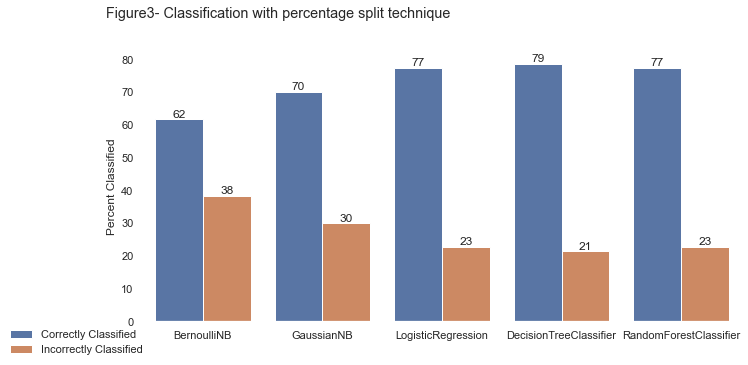

In [47]:
# plt.figure(figsize=(10,5))
g = sns.catplot(data=cm_data, y="vals", x="model", hue="cols", kind="bar")
g.despine(left=True)
g.set_axis_labels("", "Percent Classified")
g.legend.set_title("")
sns.move_legend(g, "lower left")
g.figure.set_size_inches(14.5, 4.5)

# sns.barplot(data=results_conf,y='incorrectly_classified',x='model')
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)

# iterate through the axes containers
for c in ax.containers:
    labels = [f"{(v.get_height()):.0f}" for v in c]
    ax.bar_label(c, labels=labels, label_type="edge")
# g.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
g.fig.suptitle(
    "Figure3- Classification with percentage split technique",
    horizontalalignment="left",
    x=0.1,
    y=1.1,
)
g.savefig("figure3-classification with percentage split technique.png")

In [48]:
print("class_stats_percentage_split")
results

class_stats_percentage_split


,precision,recall,fbeta,support,model
negative,0.7,0.707071,0.703518,99.0,BernoulliNB
positive,0.462963,0.454545,0.458716,55.0,BernoulliNB
negative,0.82716,0.676768,0.744444,99.0,GaussianNB
positive,0.561644,0.745455,0.640625,55.0,GaussianNB
negative,0.790909,0.878788,0.832536,99.0,LogisticRegression
positive,0.727273,0.581818,0.646465,55.0,LogisticRegression
negative,0.8,0.888889,0.842105,99.0,DecisionTreeClassifier
positive,0.75,0.6,0.666667,55.0,DecisionTreeClassifier
negative,0.790909,0.878788,0.832536,99.0,RandomForestClassifier
positive,0.727273,0.581818,0.646465,55.0,RandomForestClassifier


In [49]:
print("model_compare")
model_compare

model_compare


,Model Name,Precision,Recall,F1,Train Accuracy,Test Accuracy
0,BernoulliNB,0.581481,0.580808,0.581117,0.659609,0.616883
1,GaussianNB,0.694402,0.711111,0.692535,0.716612,0.701299
2,LogisticRegression,0.759091,0.730303,0.7395,0.758958,0.772727
3,DecisionTreeClassifier,0.775,0.744444,0.754386,0.806189,0.785714
4,RandomForestClassifier,0.759091,0.730303,0.7395,0.796417,0.772727


In [50]:
print(X.shape, y.shape)

(768, 13) (768,)


In [51]:
# split dataset in cross-validation with this splitter class:
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
# note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(
    n_splits=10, test_size=0.3, train_size=0.7, random_state=0
)

# create table to compare MLA metrics
MLA_columns = [
    "MLA Name",
    "MLA Parameters",
    "MLA Train Accuracy Mean",
    "MLA Test Accuracy Mean",
    "MLA Test Accuracy 3*STD",
    "MLA Time",
]
MLA_compare = pd.DataFrame(columns=MLA_columns)

# create table to compare MLA predictions
MLA_predict = y

In [52]:
cv_split

ShuffleSplit(n_splits=10, random_state=0, test_size=0.3, train_size=0.7)

In [53]:
results_conf = pd.DataFrame(
    columns=[
        "true_negative",
        "false_positive",
        "false_negative",
        "true_positive",
        "model",
    ]
)
# index through MLA and save performance to table
row_index = 0
for alg in MLA:

    # set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, "MLA Name"] = MLA_name
    MLA_compare.loc[row_index, "MLA Parameters"] = str(alg.get_params())

    # score model with cross validation:
    # http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(
        alg, X, y, cv=cv_split, return_train_score=True, scoring="f1_macro",
    )

    MLA_compare.loc[row_index, "MLA Time"] = cv_results["fit_time"].mean()
    MLA_compare.loc[row_index, "MLA Train Accuracy Mean"] = cv_results[
        "train_score"
    ].mean()
    MLA_compare.loc[row_index, "MLA Test Accuracy Mean"] = cv_results[
        "test_score"
    ].mean()
    # if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, "MLA Test Accuracy 3*STD"] = (
        cv_results["test_score"].std() * 3
    )  # let's know the worst that can happen!

    # save MLA predictions - see section 6 for usage
    model = alg.fit(X, y)
    y_pred = alg.predict(X)

    print(
        sklearn.metrics.precision_recall_fscore_support(y, y_pred, average="binary"),
        "\n",
    )
    prec, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(
        y, y_pred, average="binary"
    )

    flattened = sklearn.metrics.confusion_matrix(y, y_pred).ravel()
    confusion = pd.DataFrame(
        [flattened],
        columns=["true_negative", "false_positive", "false_negative", "true_positive"],
    )
    confusion["model"] = MLA_name
    results_conf = pd.concat([results_conf, confusion])

    model_compare.loc[row_index, "Model Name"] = MLA_name
    model_compare.loc[row_index, "Precision"] = prec
    model_compare.loc[row_index, "Recall"] = recall
    model_compare.loc[row_index, "F1"] = f1
    model_compare.loc[row_index, "Train Accuracy"] = cv_results["train_score"].mean()
    model_compare.loc[row_index, "Test Accuracy"] = cv_results["test_score"].mean()

    row_index += 1


results_conf = results_conf.dropna()
# print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by=["MLA Test Accuracy Mean"], ascending=False, inplace=True)
MLA_compare
# MLA_predict

(0.4672897196261682, 0.373134328358209, 0.4149377593360996, None) 

(0.5765765765765766, 0.7164179104477612, 0.6389351081530782, None) 

(0.7461928934010152, 0.5485074626865671, 0.6322580645161291, None) 

(0.7056603773584905, 0.6977611940298507, 0.7016885553470918, None) 

(0.7914438502673797, 0.5522388059701493, 0.6505494505494507, None) 



,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
2,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.727475,0.726236,0.094305,0.00641
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.751349,0.709358,0.056352,0.097658
1,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",0.699693,0.69567,0.098183,0.000795
3,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.755409,0.69486,0.079151,0.00109
0,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.608856,0.577552,0.136239,0.001198


In [54]:
results_conf["Correctly Classified"] = (
    results_conf["true_negative"] + results_conf["true_positive"]
)
results_conf["Incorrectly Classified"] = (
    y.shape[0] - results_conf["Correctly Classified"]
)

cm_data = results_conf[
    ["model", "Correctly Classified", "Incorrectly Classified"]
].melt("model", var_name="cols", value_name="vals")

In [55]:
cm_data

,model,cols,vals
0,BernoulliNB,Correctly Classified,486
1,GaussianNB,Correctly Classified,551
2,LogisticRegression,Correctly Classified,597
3,DecisionTreeClassifier,Correctly Classified,609
4,RandomForestClassifier,Correctly Classified,609
5,BernoulliNB,Incorrectly Classified,282
6,GaussianNB,Incorrectly Classified,217
7,LogisticRegression,Incorrectly Classified,171
8,DecisionTreeClassifier,Incorrectly Classified,159
9,RandomForestClassifier,Incorrectly Classified,159


In [56]:
cm_data["vals"] = cm_data["vals"] / y.shape[0] * 100

cm_data["vals"] = cm_data["vals"].apply(lambda x: round(x, 1))

cm_data

,model,cols,vals
0,BernoulliNB,Correctly Classified,63.3
1,GaussianNB,Correctly Classified,71.7
2,LogisticRegression,Correctly Classified,77.7
3,DecisionTreeClassifier,Correctly Classified,79.3
4,RandomForestClassifier,Correctly Classified,79.3
5,BernoulliNB,Incorrectly Classified,36.7
6,GaussianNB,Incorrectly Classified,28.3
7,LogisticRegression,Incorrectly Classified,22.3
8,DecisionTreeClassifier,Incorrectly Classified,20.7
9,RandomForestClassifier,Incorrectly Classified,20.7


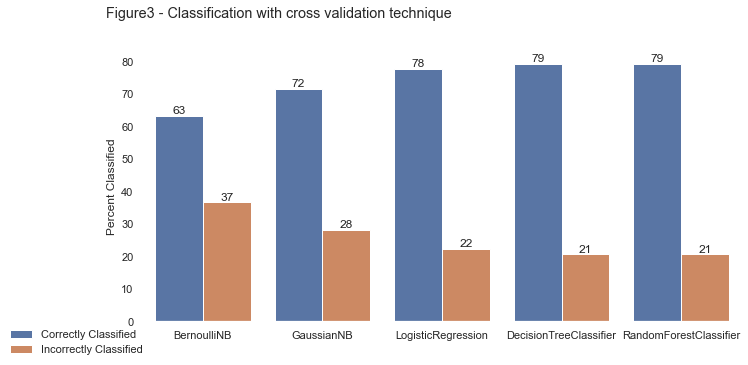

In [57]:
# plt.figure(figsize=(10,5))
g = sns.catplot(data=cm_data, y="vals", x="model", hue="cols", kind="bar")
g.despine(left=True)
g.set_axis_labels("", "Percent Classified")
g.legend.set_title("")
sns.move_legend(g, "lower left")
g.figure.set_size_inches(14.5, 4.5)

# sns.barplot(data=results_conf,y='incorrectly_classified',x='model')
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)

# iterate through the axes containers
for c in ax.containers:
    labels = [f"{(v.get_height()):.0f}" for v in c]
    ax.bar_label(c, labels=labels, label_type="edge")
g.fig.suptitle(
    "Figure3 - Classification with cross validation technique",
    horizontalalignment="left",
    x=0.1,
    y=1.1,
)
g.savefig("figure3-classification with cross validation technique.png")

In [58]:
print("10-Fold CV Results")
model_compare

10-Fold CV Results


,Model Name,Precision,Recall,F1,Train Accuracy,Test Accuracy
0,BernoulliNB,0.46729,0.373134,0.414938,0.608856,0.577552
1,GaussianNB,0.576577,0.716418,0.638935,0.699693,0.69567
2,LogisticRegression,0.746193,0.548507,0.632258,0.727475,0.726236
3,DecisionTreeClassifier,0.70566,0.697761,0.701689,0.755409,0.69486
4,RandomForestClassifier,0.791444,0.552239,0.650549,0.751349,0.709358


In [92]:
alg = tree.DecisionTreeClassifier(max_depth=3)

In [93]:
cv_results = model_selection.cross_validate(
    alg, X, y, cv=cv_split, return_train_score=True, scoring="f1_macro",
)

# save MLA predictions - see section 6 for usage
model = alg.fit(X, y)
y_pred = alg.predict(X)

In [94]:
sklearn.metrics.precision_recall_fscore_support(y, y_pred, average="binary")

(0.6942148760330579, 0.6268656716417911, 0.6588235294117648, None)

In [95]:
prec, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(
    y, y_pred, average="binary"
)

In [96]:
variable_importance = pd.DataFrame(
    model.feature_importances_,
    index=column_trans.get_feature_names_out().tolist(),
    columns=["importance"],
)

In [97]:
variable_importance.sort_values("importance", ascending=False)

,importance
minmax__glucose,0.735558
minmax__bmi,0.264442
"one_hot__age_(20.999, 22.0]",0.000000
"one_hot__age_(22.0, 25.0]",0.000000
"one_hot__age_(25.0, 29.0]",0.000000
"one_hot__age_(29.0, 36.0]",0.000000
"one_hot__age_(36.0, 45.0]",0.000000
"one_hot__age_(45.0, 81.0]",0.000000
minmax__pregnancies,0.000000
minmax__bloodpressure,0.000000


In [98]:
import graphviz 

In [99]:
dot_data = tree.export_graphviz(model, filled=True,rounded=True,special_characters=True,out_file='pima_tree.dot',
                                feature_names = column_trans.get_feature_names_out(),class_names=['No Diabetes','Diabetes'])

In [101]:
graph = graphviz.render('dot', filepath='pima_tree.dot',outfile='pima_tree.png').replace('\\', '/')
graph

'pima_tree.png'

In [ ]:
dot_data = sklearn.tree.export_graphviz(
    model,
    out_file="tree.dot",
    filled=True,
    rounded=True,
    special_characters=True
    # feature_names=column_trans.get_feature_names_out(),
    # class_names=["No Diabetes", "Diabetes"],
)

In [ ]:
graph = graphviz.Source(dot_data)

In [ ]:
dot_data

In [ ]:
model.estimators_[0]

In [ ]:
dot_data = export_graphviz(
    model.estimators_[0],
    out_file="tree.dot",
    feature_names=column_trans.get_feature_names_out(),
    class_names=["Diabetes", "No Diabetes"],
    rounded=True,
    proportion=False,
    precision=2,
    filled=True,
)

In [ ]:
!dot -V

In [ ]:
from subprocess import call

call(["dot", "-Tpng", "tree.dot", "-o", "tree.png", "-Gdpi=600"])

In [ ]:
import graphviz

In [ ]:
graph = graphviz.Source(dot_data)

In [ ]:
graph

In [ ]:
import shap

In [ ]:
# load JS visualization code to notebook
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [ ]:
len(shap_values)

In [ ]:
sylhet_copy.columns

In [ ]:
my_fig = shap.summary_plot(
    shap_values, features=X, feature_names=column_trans.get_feature_names_out(),
)

In [102]:
alg = linear_model.LogisticRegression(penalty='l1',solver='liblinear')

In [103]:
cv_results = model_selection.cross_validate(
    alg, X, y, cv=cv_split, return_train_score=True, scoring="f1_macro",
)

# save MLA predictions - see section 6 for usage
model = alg.fit(X, y)
y_pred = alg.predict(X)

In [104]:
sklearn.metrics.precision_recall_fscore_support(y, y_pred, average="binary")

(0.7365853658536585, 0.5634328358208955, 0.638477801268499, None)

In [105]:
np.set_printoptions(suppress=True)

In [106]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [107]:
model.coef_

array([[-1.18364997, -0.7304821 , -0.49517741,  0.14653216,  0.04096486,
         0.        ,  1.01822555,  5.90968993, -1.15281664,  0.        ,
        -0.05965598,  4.29305094,  1.44702792]])

In [108]:
np.exp(model.coef_)

array([[  0.30615922,   0.48167672,   0.60946277,   1.15781217,
          1.04181549,   1.        ,   2.76827823, 368.5918495 ,
          0.31574617,   1.        ,   0.94208857,  73.18942486,
          4.25046299]])

In [109]:
var_coef = pd.DataFrame(
    np.exp(model.coef_)[0],
    index=column_trans.get_feature_names_out().tolist(),
    columns=["lr_coefficient"],
)

In [110]:
var_coef.sort_values('lr_coefficient',ascending=False)

,lr_coefficient
minmax__glucose,368.59185
minmax__bmi,73.18942
minmax__diabetespedigreefunction,4.25046
minmax__pregnancies,2.76828
"one_hot__age_(29.0, 36.0]",1.15781
"one_hot__age_(36.0, 45.0]",1.04182
"one_hot__age_(45.0, 81.0]",1.00000
minmax__skinthickness,1.00000
minmax__insulin,0.94209
"one_hot__age_(25.0, 29.0]",0.60946


In [ ]:
explainer = shap.LinearExplainer(model, X)
shap_values = explainer.shap_values(X)

In [ ]:
shap.summary_plot(shap_values, X, feature_names=column_trans.get_feature_names_out())

In [ ]:
# barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x="MLA Test Accuracy Mean", y="MLA Name", data=MLA_compare, color="m")

# prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title("Machine Learning Algorithm Accuracy Score \n")
plt.xlabel("Accuracy Score (%)")
plt.ylabel("Algorithm")

In [ ]:
MLA_compare